In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.inspection import permutation_importance
from sklearn.tree import plot_tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset
re = pd.read_csv('https://raw.githubusercontent.com/zd2425/bootcamp_final/refs/heads/main/real_estate_dataset.csv')

In [3]:
re.head()

,ID,Square_Feet,Num_Bedrooms,Num_Bathrooms,Num_Floors,Year_Built,Has_Garden,Has_Pool,Garage_Size,Location_Score,Distance_to_Center,Price
0,1,143.635030,1,3,3,1967,1,1,48,8.297631,5.935734,602134.816747
1,2,287.678577,1,2,1,1949,0,1,37,6.061466,10.827392,591425.135386
2,3,232.998485,1,3,2,1923,1,0,14,2.911442,6.904599,464478.696880
3,4,199.664621,5,2,2,1918,0,0,17,2.070949,8.284019,583105.655996
4,5,89.004660,4,3,3,1999,1,0,34,1.523278,14.648277,619879.142523


In [4]:
y = re['Price']
X = re.drop(['Price','ID'], axis=1)

In [5]:
X.head()

,Square_Feet,Num_Bedrooms,Num_Bathrooms,Num_Floors,Year_Built,Has_Garden,Has_Pool,Garage_Size,Location_Score,Distance_to_Center
0,143.635030,1,3,3,1967,1,1,48,8.297631,5.935734
1,287.678577,1,2,1,1949,0,1,37,6.061466,10.827392
2,232.998485,1,3,2,1923,1,0,14,2.911442,6.904599
3,199.664621,5,2,2,1918,0,0,17,2.070949,8.284019
4,89.004660,4,3,3,1999,1,0,34,1.523278,14.648277


In [6]:
y.describe()

,Price
count,500.000000
mean,582209.629529
std,122273.390345
min,276892.470136
25%,503080.344140
50%,574724.113347
75%,665942.301274
max,960678.274291


In [7]:
# Calculate the mean of the target variable (Price)
baseline_prediction = y.mean()

# Create an array with the same value (mean) for all instances in y
y_baseline = [baseline_prediction] * np.ones(len(re))

# Calculate the baseline MSE
baseline_mse = mean_squared_error(y, y_baseline)

print(f"Baseline MSE (using mean price): {baseline_mse:.2f}")

Baseline MSE (using mean price): 14920880422.51


In [8]:
# Split the data into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [9]:
# Iterate over polynomial degrees from 1 to 4
for degree in range(1, 5):
    # Define the pipeline
    LinearPipe = Pipeline([
        ('scaler', StandardScaler()),                # Step 1: Standardize the features
        ('poly', PolynomialFeatures(degree=degree)), # Step 2: Create polynomial features
        ('lin_reg', LinearRegression())              # Step 3: Train Linear Regression model
    ])

    # Fit the pipeline on training data
    LinearPipe.fit(X_train, y_train)

    # Predict on the train set and test set
    y_train_pred = LinearPipe.predict(X_train)
    y_test_pred = LinearPipe.predict(X_test)

    # Calculate MSE for train and test sets
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # Print results for the current degree
    print(f"Degree: {degree}")
    print(f"Train MSE: {train_mse:.2f}")
    print(f"Test MSE: {test_mse:.2f}")
    print("-" * 40)

Degree: 1
Train MSE: 342547815.54
Test MSE: 437730359.71
----------------------------------------
Degree: 2
Train MSE: 299991409.65
Test MSE: 518559235.05
----------------------------------------
Degree: 3
Train MSE: 136564670.21
Test MSE: 1164557142.71
----------------------------------------
Degree: 4
Train MSE: 0.00
Test MSE: 1669226891.80
----------------------------------------


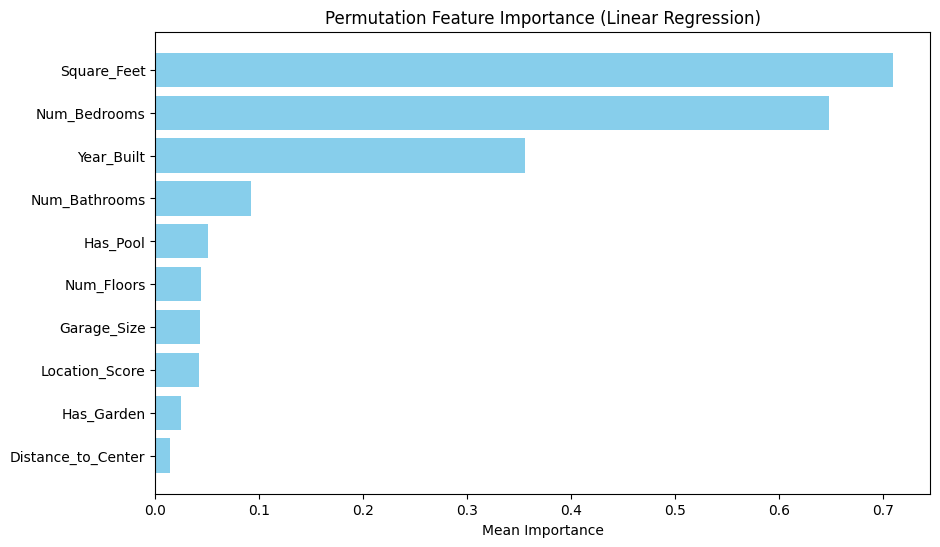

              Feature  Importance
0         Square_Feet    0.709822
1        Num_Bedrooms    0.648168
4          Year_Built    0.355263
2       Num_Bathrooms    0.091814
6            Has_Pool    0.050793
3          Num_Floors    0.043605
7         Garage_Size    0.043370
8      Location_Score    0.042298
5          Has_Garden    0.024797
9  Distance_to_Center    0.014682


In [10]:
# Permutation Feature Importance
perm_importance = permutation_importance(LinearPipe, X_test, y_test, n_repeats=15, random_state=42)

# Create a DataFrame to display results
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Permutation Feature Importance (Linear Regression)')
plt.xlabel('Mean Importance')
plt.gca().invert_yaxis()
plt.show()

# Display the sorted importance values
print(importance_df)

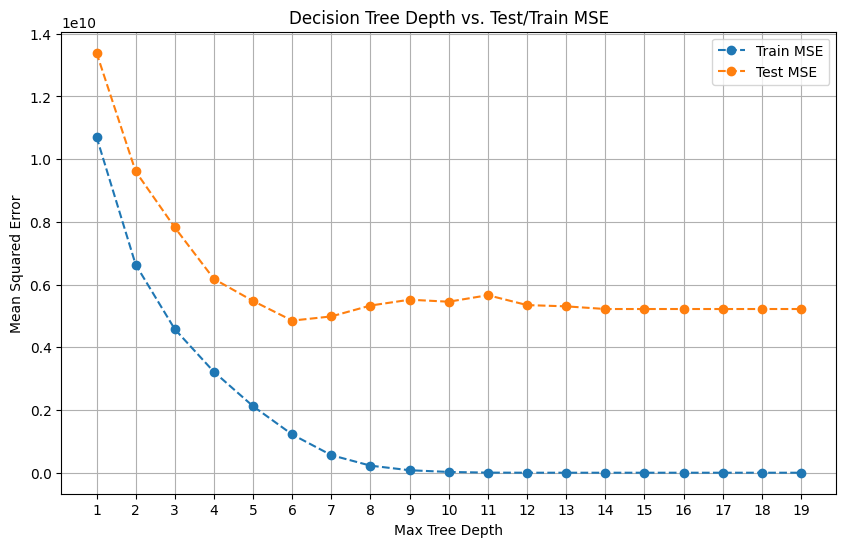

Optimal max_depth: 6
Minimum Test MSE: 4851212956.41


In [11]:
# Initialize lists to store errors
train_mse = []
test_mse = []

# Loop through max_depth values to find the optimal depth
depths = range(1, 20)
for d in depths:
    # Define pipeline with Decision Tree and scaling
    treepipe = Pipeline([
        ('scaler', StandardScaler()),
        ('dt_regressor', DecisionTreeRegressor(max_depth=d, random_state=42))
    ])

    # Train the model
    treepipe.fit(X_train, y_train)

    # Predict on training and testing sets
    y_train_pred = treepipe.predict(X_train)
    y_test_pred = treepipe.predict(X_test)

    # Calculate and store MSE
    train_mse.append(mean_squared_error(y_train, y_train_pred))
    test_mse.append(mean_squared_error(y_test, y_test_pred))

# Plot train and test MSE to identify the optimal max_depth
plt.figure(figsize=(10, 6))
plt.plot(depths, train_mse, '--o', label='Train MSE')
plt.plot(depths, test_mse, '--o', label='Test MSE')
plt.xlabel('Max Tree Depth')
plt.ylabel('Mean Squared Error')
plt.title('Decision Tree Depth vs. Test/Train MSE')
plt.legend()
plt.grid()
plt.xticks(depths)
plt.show()

# Find the optimal max_depth based on minimum test MSE
optimal_depth = depths[test_mse.index(min(test_mse))]
print(f"Optimal max_depth: {optimal_depth}")
print(f"Minimum Test MSE: {min(test_mse):.2f}")

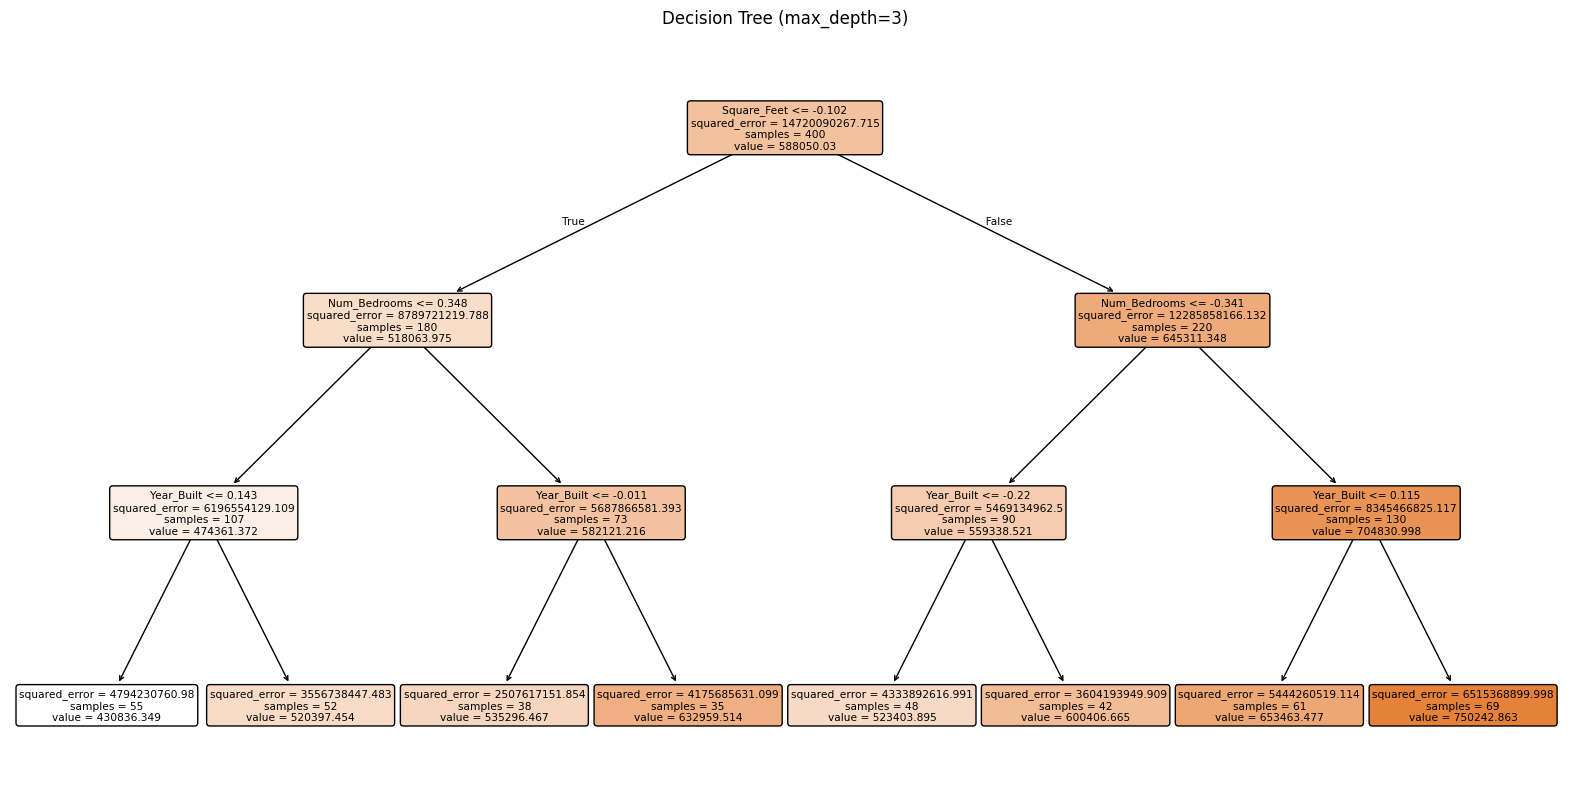

In [12]:
# Train the Decision Tree Regressor with optimal max_depth
optimal_treepipe = Pipeline([
    ('scaler', StandardScaler()),
    ('dt_regressor', DecisionTreeRegressor(max_depth=3, random_state=42))
])
optimal_treepipe.fit(X_train, y_train)

# Extract the trained Decision Tree model
optimal_tree = optimal_treepipe.named_steps['dt_regressor']

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(optimal_tree,
          feature_names=X.columns,
          filled=True,
          rounded=True,
          max_depth=optimal_depth)
plt.title(f"Decision Tree (max_depth={3})")
plt.show()

In [17]:
rfrpipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

# Define the grid of hyperparameters to search
param_grid = {
    'rf__n_estimators': [10, 30, 50, 100, 150],        # Number of trees in the forest
    'rf__max_depth': [None, 3, 6, 10, 20],       # Maximum depth of each tree
    'rf__min_samples_split': [2, 5, 10],       # Minimum samples to split an internal node
    'rf__min_samples_leaf': [1, 2, 4]          # Minimum samples at each leaf node
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rfrpipe, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict on test set using the best model
y_test_pred = best_model.predict(X_test)

# Calculate Test MSE
test_mse = mean_squared_error(y_test, y_test_pred)

# Print Results
print("Best Hyperparameters:", best_params)
print(f"Test MSE: {test_mse:.2f}")

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
Best Hyperparameters: {'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 150}
Test MSE: 2683887888.89


Permutation Feature Importance:
              Feature  Importance
0         Square_Feet    0.634403
1        Num_Bedrooms    0.558818
4          Year_Built    0.306926
2       Num_Bathrooms    0.022052
6            Has_Pool    0.013883
7         Garage_Size    0.009905
3          Num_Floors    0.008506
9  Distance_to_Center    0.006579
8      Location_Score    0.006413
5          Has_Garden    0.003314


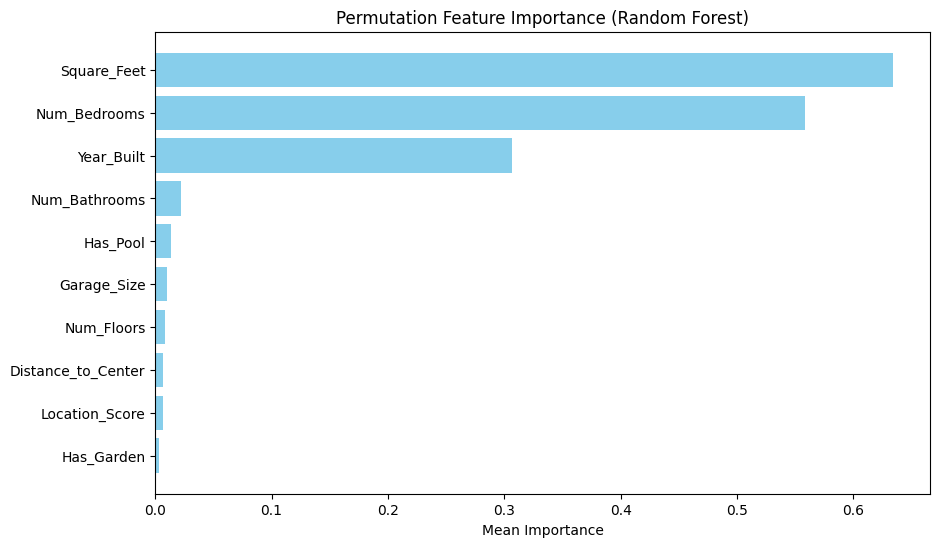

In [14]:
# Calculate permutation importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=30, random_state=42)

# Extract feature importance and display in a DataFrame
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

# Print the feature importance
print("Permutation Feature Importance:")
print(importance_df)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Permutation Feature Importance (Random Forest)')
plt.xlabel('Mean Importance')
plt.gca().invert_yaxis()
plt.show()

In [15]:
# Define a pipeline with StandardScaler and KNN
knnpipe = Pipeline([
    ('scaler', StandardScaler()),                # Feature scaling
    ('knn', KNeighborsRegressor())               # KNN model
])

# Define a parameter grid for GridSearchCV
param_grid = {
    'knn__n_neighbors': [1, 3, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50],        # Number of neighbors to consider
}

# Initialize GridSearchCV to tune hyperparameters
grid_search_knn = GridSearchCV(knnpipe, param_grid, cv=5,
                               scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search_knn.fit(X_train, y_train)

# Get the best parameters and model
best_knn_model = grid_search_knn.best_estimator_
best_params = grid_search_knn.best_params_

# Predict on test set
y_test_pred = best_knn_model.predict(X_test)

# Evaluate the model
test_mse = mean_squared_error(y_test, y_test_pred)

# Print results
print("Best Hyperparameters for KNN:", best_params)
print(f"Test MSE for KNN: {test_mse:.2f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters for KNN: {'knn__n_neighbors': 6}
Test MSE for KNN: 4615926745.49


Permutation Feature Importance (KNN):
              Feature  Importance
0         Square_Feet    0.634403
1        Num_Bedrooms    0.558818
4          Year_Built    0.306926
2       Num_Bathrooms    0.022052
6            Has_Pool    0.013883
7         Garage_Size    0.009905
3          Num_Floors    0.008506
9  Distance_to_Center    0.006579
8      Location_Score    0.006413
5          Has_Garden    0.003314


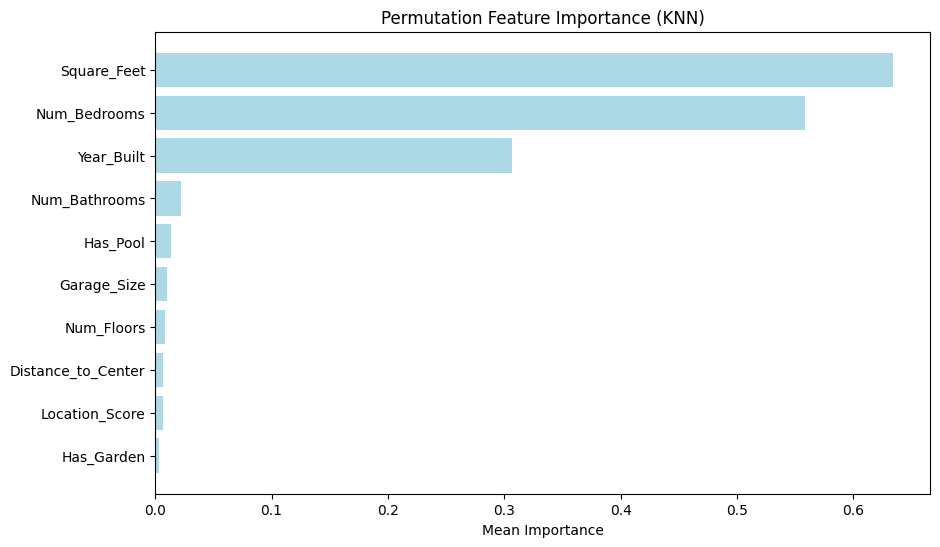

In [16]:
# Convert results to a DataFrame
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

# Display the results
print("Permutation Feature Importance (KNN):")
print(importance_df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='lightblue')
plt.title('Permutation Feature Importance (KNN)')
plt.xlabel('Mean Importance')
plt.gca().invert_yaxis()
plt.show()